In [1]:
#%%capture
!apt-get update
# Install GDAL and Geopandas
!apt-get install libgdal-dev 
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [2]:
%pip install "dask[complete]"
%pip install "dask[complete]" --upgrade

In [3]:
#%%capture
%pip install pystac_client planetary_computer rasterio xarray-spatial

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# One may also need to add a shortcut to the shared drive like in 
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab/54352105#54352105

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

from google.colab import files
from datetime import datetime

from pystac_client import Client
import planetary_computer
import xarray
import dask.dataframe as dd
import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation
from datashader.utils import export_image

## Data Ingestion

Duplicate of SnowCast Showdown as of 2/13/2022

In [9]:
gridcells = gpd.read_file('/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/grid_cells.geojson')
print(gridcells.head())

                                cell_id  ...                                           geometry
0  0003f387-71c4-48f6-b2b0-d853bd4f0aba  ...  POLYGON ((-118.71895 37.07419, -118.71895 37.0...
1  000617d8-8c14-43e2-b708-7e3a69fe3cc3  ...  POLYGON ((-107.07679 37.78042, -107.07679 37.7...
2  000863e7-21e6-477d-b799-f5675c348627  ...  POLYGON ((-119.40167 37.02400, -119.40167 37.0...
3  000ba8d9-d6d5-48da-84a2-1fa54951fae1  ...  POLYGON ((-119.32082 37.43171, -119.32082 37.4...
4  00146204-d4e9-4cd8-8f86-d1ef133c5b6d  ...  POLYGON ((-118.52132 36.65735, -118.52132 36.6...

[5 rows x 3 columns]


In [10]:
traindf = pd.read_csv("/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/train_labels.csv")

traindf = traindf.melt(id_vars=["cell_id"]).dropna().reset_index(drop = True)
traindf.rename(columns = {"cell_id":"cell_id", "variable":"date", "value":"SWE"}, inplace = True)

traindf = traindf.merge(gridcells, how = 'left', on='cell_id')


traindf = gpd.GeoDataFrame(traindf, crs ="EPSG:4326")
traindf

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."
...,...,...,...,...,...
91485,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,central rockies,"POLYGON ((-105.07354 38.87270, -105.07354 38.8..."
91486,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,central rockies,"POLYGON ((-106.10661 39.29804, -106.10661 39.3..."
91487,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,central rockies,"POLYGON ((-107.92120 37.79462, -107.92120 37.8..."
91488,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,other,"POLYGON ((-122.02475 43.89659, -122.02475 43.9..."


In [11]:
from datetime import datetime, timedelta

print(len(traindf.loc[pd.to_datetime(traindf.date) > datetime.strptime("2016-01-01", "%Y-%m-%d"), "region"]))
print(len(traindf.loc[traindf["region"] == "sierras", "region"]))

68670
37017


In [13]:
traindf.head()

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."


In [14]:
import shutil
import os
import requests
import ee
from datetime import datetime, timedelta

traindf["date"] = pd.to_datetime(traindf.date)
#trainfeatures['date'] = pd.to_datetime(trainfeatures.date)

#I am creating a string version of the date to use as a filename
traindf["datestring"] = traindf.date.map(lambda d: str(d.year)+d.strftime('%j'))

#Now I calculate my centroid from the provided geometry
#Ignore the warnings this creates. It is in a projected crs
traindf["centroid"] = traindf.geometry.to_crs('+proj=cea').centroid
traindf["center_lat"] = traindf.centroid.y
traindf["center_long"] = traindf.centroid.x

#Logging in to Earth Engine
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

Exception ignored in: <function BaseGeometry.__del__ at 0x7fb9703bd200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/shapely/geometry/base.py", line 209, in __del__
    self._empty(val=None)
  File "/usr/local/lib/python3.7/dist-packages/shapely/geometry/base.py", line 192, in _empty
    if not self._other_owned and self.__geom__ and self.__geom__ != EMPTY:
KeyboardInterrupt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=n8K8fTZrCL-AYRW8pgFp_A5bnD9AnlVKMES2ADeSRiE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhQXUY88g6S_UO7e0N6fVOB0QbyQUvRO5S0a14VxTTVBPvHOO9iWek

Successfully saved authorization token.


In [35]:
from shapely.geometry import Point

In [36]:
for pt in list(traindf.geometry[0].exterior.coords): 
        print (Point(pt))

POINT (-121.9349218899677 41.163266139578)
POINT (-121.9349218899677 41.17002864097398)
POINT (-121.9439050428089 41.17002864097398)
POINT (-121.9439050428089 41.163266139578)
POINT (-121.9349218899677 41.163266139578)


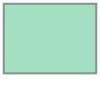

In [34]:
traindf.geometry[0]

## Sentinel 2 Data Planetary Computer Data

In [16]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [70]:
pip install rioxarray

     |████████████████████████████████| 47 kB 2.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=16ebd592a7b9ba16716aa6467355a401cc92e7b7a9b18b064bb1a684eae55439
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [77]:
import pystac
import rioxarray
import xrspatial
import pystac_client
import xarray as xr

### Running through single sample from notebook: https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook

Exploration based on: https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

TO ADAPT:
https://planetarycomputer.microsoft.com/docs/tutorials/hurricane-florence-animation/ 

In [64]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
collections = catalog.get_children()

In [17]:
time_of_interest = "2019-06-01/2019-08-01"

In [37]:
area_of_interest = traindf['geometry'][0]

In [73]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")
print(items)

Returned 18 Items
[<Item id=S2A_MSIL2A_20190801T185921_R013_T10TEL_20201004T190928>, <Item id=S2A_MSIL2A_20190729T184921_R113_T10TEL_20201106T050500>, <Item id=S2B_MSIL2A_20190727T185929_R013_T10TEL_20201106T033958>, <Item id=S2B_MSIL2A_20190724T184929_R113_T10TEL_20201005T191201>, <Item id=S2A_MSIL2A_20190722T185921_R013_T10TEL_20201005T180047>, <Item id=S2A_MSIL2A_20190719T184921_R113_T10TEL_20201005T162510>, <Item id=S2B_MSIL2A_20190717T185929_R013_T10TEL_20201005T154027>, <Item id=S2B_MSIL2A_20190714T184929_R113_T10TEL_20201005T141005>, <Item id=S2A_MSIL2A_20190712T185921_R013_T10TEL_20201005T125733>, <Item id=S2B_MSIL2A_20190707T185929_R013_T10TEL_20201005T104951>, <Item id=S2B_MSIL2A_20190704T184929_R113_T10TEL_20201005T092336>, <Item id=S2A_MSIL2A_20190702T185921_R013_T10TEL_20201005T081331>, <Item id=S2A_MSIL2A_20190629T184921_R113_T10TEL_20201006T075110>, <Item id=S2A_MSIL2A_20190619T184921_R113_T10TEL_20201006T040817>, <Item id=S2B_MSIL2A_20190617T185929_R013_T10TEL_20201106T

In [94]:
least_cloudy_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]
least_cloudy_item_list = sorted(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20190724T184929_R113_T10TEL_20201005T191201 from 2019-07-24 with 0.093364% cloud cover


In [87]:
for asset in least_cloudy_item.assets.items():
    print(f"{asset}")

('AOT', <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/T/EL/2019/07/24/S2B_MSIL2A_20190724T184929_N0212_R113_T10TEL_20201005T191201.SAFE/GRANULE/L2A_T10TEL_A012437_20190724T185631/IMG_DATA/R10m/T10TEL_20190724T184929_AOT_10m.tif>)
('B01', <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/T/EL/2019/07/24/S2B_MSIL2A_20190724T184929_N0212_R113_T10TEL_20201005T191201.SAFE/GRANULE/L2A_T10TEL_A012437_20190724T185631/IMG_DATA/R60m/T10TEL_20190724T184929_B01_60m.tif>)
('B02', <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/T/EL/2019/07/24/S2B_MSIL2A_20190724T184929_N0212_R113_T10TEL_20201005T191201.SAFE/GRANULE/L2A_T10TEL_A012437_20190724T185631/IMG_DATA/R10m/T10TEL_20190724T184929_B02_10m.tif>)
('B03', <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/T/EL/2019/07/24/S2B_MSIL2A_20190724T184929_N0212_R113_T10TEL_20201005T191201.SAFE/GRANULE/L2A_T10TEL_A012437_20190724T185631/IMG_DATA/R10m/T10TEL_20

In [86]:
ds = rioxarray.open_rasterio(least_cloudy_item.assets["visual"].href).load()
ds[0].plot.imshow(figsize=(16, 9), cmap="Blues");

RasterioIOError: ignored

In [88]:
bands = ["B02", "B11", "B12"]
common_names = [
  items[0].assets[band].extra_fields["eo:bands"][0]["common_name"] for band in bands             
]


In [98]:
rgb = xr.concat([least_cloudy_item], dim="band").sel(band= ['B02', 'B11', 'B12'])

TypeError: ignored

In [90]:
common_names

['blue', 'swir16', 'swir22']

In [40]:
asset_href = least_cloudy_item.assets["visual"].href

In [62]:
temp = least_cloudy_item.sel(band="B08")
temp

AttributeError: ignored

In [41]:
signed_href = pc.sign(asset_href)

In [42]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

with rasterio.open(signed_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

In [55]:
print(band_data.shape)
(band_data)

(3, 75, 76)


array([[[24, 27, 27, ..., 35, 38, 43],
        [25, 28, 28, ..., 37, 37, 39],
        [26, 22, 22, ..., 42, 43, 36],
        ...,
        [65, 49, 41, ..., 47, 39, 35],
        [53, 52, 43, ..., 64, 48, 35],
        [46, 33, 31, ..., 88, 68, 47]],

       [[36, 38, 38, ..., 41, 46, 46],
        [33, 42, 36, ..., 44, 45, 43],
        [38, 34, 31, ..., 41, 43, 41],
        ...,
        [67, 56, 49, ..., 60, 50, 53],
        [56, 50, 49, ..., 78, 56, 53],
        [49, 41, 44, ..., 86, 67, 65]],

       [[18, 22, 19, ..., 24, 23, 30],
        [18, 25, 21, ..., 24, 25, 25],
        [21, 20, 17, ..., 28, 27, 21],
        ...,
        [42, 36, 31, ..., 36, 31, 29],
        [34, 32, 29, ..., 47, 35, 32],
        [29, 25, 24, ..., 60, 48, 36]]], dtype=uint8)

In [58]:
temp = np.transpose(band_data, axes=[1, 2, 0])
print(temp.shape)
print(temp)

(75, 76, 3)
[[[24 36 18]
  [27 38 22]
  [27 38 19]
  ...
  [35 41 24]
  [38 46 23]
  [43 46 30]]

 [[25 33 18]
  [28 42 25]
  [28 36 21]
  ...
  [37 44 24]
  [37 45 25]
  [39 43 25]]

 [[26 38 21]
  [22 34 20]
  [22 31 17]
  ...
  [42 41 28]
  [43 43 27]
  [36 41 21]]

 ...

 [[65 67 42]
  [49 56 36]
  [41 49 31]
  ...
  [47 60 36]
  [39 50 31]
  [35 53 29]]

 [[53 56 34]
  [52 50 32]
  [43 49 29]
  ...
  [64 78 47]
  [48 56 35]
  [35 53 32]]

 [[46 49 29]
  [33 41 25]
  [31 44 24]
  ...
  [88 86 60]
  [68 67 48]
  [47 65 36]]]


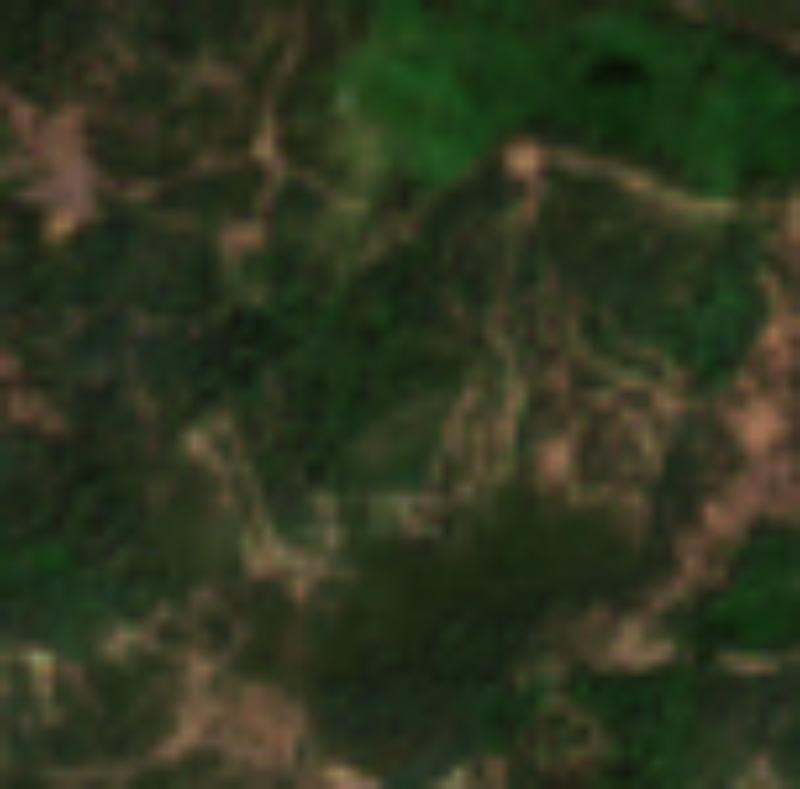

In [43]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.BILINEAR)

In [48]:
#filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_Data/test.png')
img.save('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_Data/test.png')

In [59]:
img.shape

AttributeError: ignored

##Main Function

In [ ]:
def get_sentinel2(traindf, overwrite = False):
  traindf["sentinel2_filelocations"] = "blank"
  x = 0
  length_cell_id = len(traindf.cell_id.unique())
  time_of_interest = "2019-06-01/2019-08-01"

  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id + '_sentinel2_' + traindf.datestring[i]+ '.png'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_Data', pict_name)

    # Adapted from https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook and work done for copernicus in main notebook:
    
    if not os.path.exists(filename + '.png') or overwrite:
      client = Client.open(
          "https://planetarycomputer.microsoft.com/api/stac/v1",
          ignore_conformance=True,
      )

      point = [traindf.loc[traindf.cell_id == i, "center_long"].iloc[0], 
              traindf.loc[traindf.cell_id == i, "center_lat"].iloc[0]]
      
      search = client.search(
          collections=["sentinel-2-12a"],
          intersects={"type": "Point", "coordinates": point},
          datetime = time_of_interest,
          query={"eo:cloud_cover": {"lt": 10}},
      )

      items = list(search.get_items())
      print(f"Returned {len(items)} Items")

      least_cloudy_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

      print(
        f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
        f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
      )

      items = list(search.get_items())

      signed_asset = planetary_computer.sign(items[0].assets["data"])
      
      data = (
          xarray.open_rasterio(signed_asset.href)
          .squeeze()
          .drop("band")
          .mean()
      )
      min_lon = min([j[0] for j in [y for y in traindf.loc[traindf.cell_id == i, "geometry"].iloc[0].centroid.buffer(.05).boundary.coords]])
      min_lat = min([j[1] for j in [y for y in traindf.loc[traindf.cell_id == i, "geometry"].iloc[0].centroid.buffer(.05).boundary.coords]])
      max_lon = max([j[0] for j in [y for y in traindf.loc[traindf.cell_id == i, "geometry"].iloc[0].centroid.buffer(.05).boundary.coords]])
      max_lat = max([j[1] for j in [y for y in traindf.loc[traindf.cell_id == i, "geometry"].iloc[0].centroid.buffer(.05).boundary.coords]])

      mask_lon = (data.x >= min_lon) & (data.x <= max_lon)
      mask_lat = (data.y >= min_lat) & (data.x <= max_lat)

      cropped_data = data.where(mask_lon & mask_lat, drop=True)

      hillshade = xrspatial.hillshade(cropped_data)
      img = stack(shade(hillshade, cmap=["white", "gray"]), shade(cropped_data, cmap=Elevation, alpha=128))
      export_image(img=img, filename=filename, background=None)

    traindf.loc[traindf.cell_id == i, "copernicus_filelocations"] = filename + '.png'
    if x % 500 == 0:
      print(f'{x} out of {length_cell_id} complete')
    x += 1

##Image testing

(75, 76, 3)
The image consists of 5700 pixels


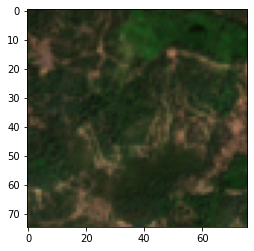

In [49]:
test1=plt.imread('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_Data/test.png')
print(test1.shape)
print(f"The image consists of {test1.shape[0] * test1.shape[1]} pixels")
plt.imshow(test1);

In [50]:
test1

array([[[0.09411765, 0.14117648, 0.07058824],
        [0.10588235, 0.14901961, 0.08627451],
        [0.10588235, 0.14901961, 0.07450981],
        ...,
        [0.13725491, 0.16078432, 0.09411765],
        [0.14901961, 0.18039216, 0.09019608],
        [0.16862746, 0.18039216, 0.11764706]],

       [[0.09803922, 0.12941177, 0.07058824],
        [0.10980392, 0.16470589, 0.09803922],
        [0.10980392, 0.14117648, 0.08235294],
        ...,
        [0.14509805, 0.17254902, 0.09411765],
        [0.14509805, 0.1764706 , 0.09803922],
        [0.15294118, 0.16862746, 0.09803922]],

       [[0.10196079, 0.14901961, 0.08235294],
        [0.08627451, 0.13333334, 0.07843138],
        [0.08627451, 0.12156863, 0.06666667],
        ...,
        [0.16470589, 0.16078432, 0.10980392],
        [0.16862746, 0.16862746, 0.10588235],
        [0.14117648, 0.16078432, 0.08235294]],

       ...,

       [[0.25490198, 0.2627451 , 0.16470589],
        [0.19215687, 0.21960784, 0.14117648],
        [0.16078432, 0